# Mount Drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


# Build input pipeline

In [ ]:
def normalize(image):
    """Images are resized --> (64, 64, 3) and normalized --> [-1, 1]"""
    image = tf.keras.preprocessing.image.smart_resize(image, (64, 64))

    return tf.cast(image, tf.float32)/127.5-1

batch_size = 256

ds_train = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/detectable", labels=None, batch_size=None
).map(normalize).shuffle(1000).batch(batch_size)

Found 8535 files belonging to 1 classes.


# Define model

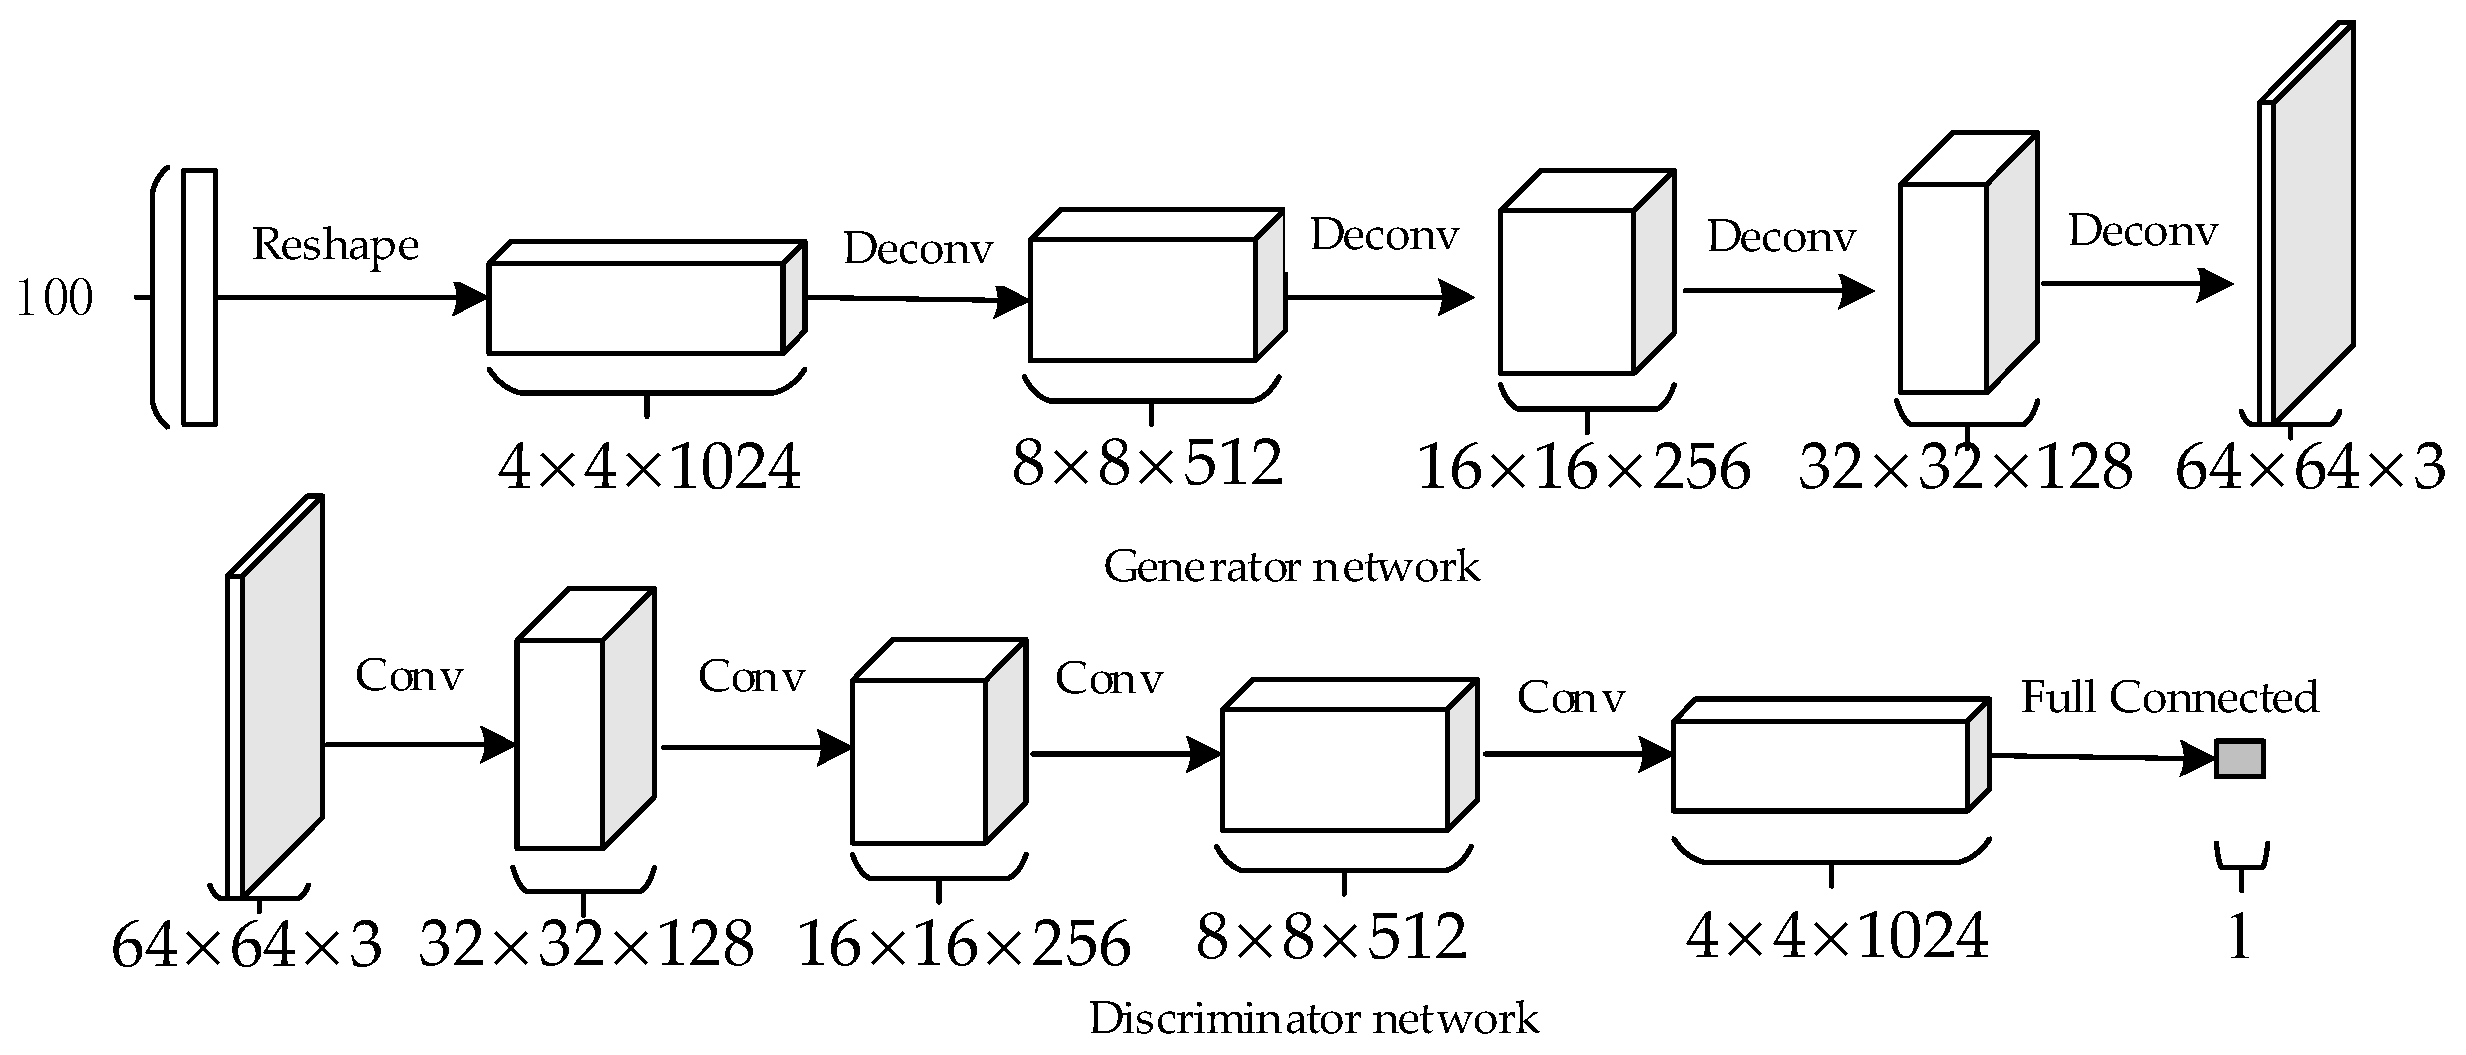

In [ ]:
########################################
# Unsupervised Representation Learning #
# with Deep Convolutional              #
# Generative Adversarial Networks      #
#                                      #
# Chintala, Metz, Radford              #
#                                      #
# https://arxiv.org/pdf/1511.06434.pdf #
########################################

def deconv(units, activation="relu"):
    # Weights ~ N(0, 0.02)
    initializer = tf.keras.initializers.RandomNormal(stddev=0.02)

    # Deconvolution --> Batch Normalization --> Activation
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(units, kernel_size=(5, 5), strides=(2, 2),
                                        padding="same", kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization()
    ])

    assert activation == "relu" or activation == "tanh", "Invalid activation function."

    if activation == "relu":
        block.add(tf.keras.layers.ReLU())
    else:
        block.add(tf.keras.layers.Activation(tf.keras.activations.tanh))

    return block

def generator():
    """Generator G maps 100-D latent space Z (sampled from N(0, 1)) to 64x64x3 image"""
    inputs = tf.keras.Input(shape=(100,))         # (None, 100)

    x = tf.keras.layers.Dense(4*4*1024)(inputs)   # (None, 4*4*1024)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Reshape((4, 4, 1024))(x)  # (None, 4, 4, 1024)

    x = deconv(512)(x)                            # (None, 8, 8, 512)
    x = deconv(256)(x)                            # (None, 16, 16, 256)
    x = deconv(128)(x)                            # (None, 32, 32, 128)

    outputs = deconv(3, activation="tanh")(x)     # (None, 64, 64, 3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

def conv(units):
    # Weights ~ N(0, 0.02)
    initializer = tf.keras.initializers.RandomNormal(stddev=0.02)

    # Convolution --> Batch Normalization --> Activation
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(units, kernel_size=(5, 5), strides=(2, 2),
                               padding="same", kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])

    return block

def discriminator():
    """Discriminator D maps 64x64x3 image to real/fake prediction"""
    inputs = tf.keras.Input(shape=(64, 64, 3))  # (None, 64, 64, 3)

    x = conv(128)(inputs)                       # (None, 32, 32, 128)
    x = conv(256)(x)                            # (None, 16, 16, 256)
    x = conv(512)(x)                            # (None, 8, 8, 512)
    x = conv(1024)(x)                           # (None, 4, 4, 1024)

    x = tf.keras.layers.Flatten()(x)            # (None, 4*4*1024)
    outputs = tf.keras.layers.Dense(1)(x)       # (None, 1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

gen = generator()
disc = discriminator()

# Define training parameters

In [ ]:
crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def disc_loss_fn(real_logits, fake_logits):
    """
    Discriminator should classify real images as real generated images as fake

    Loss L = Divergence from 1's for real images +
             Divergence from 0's for fake images
    """
    real_loss = crossentropy(tf.ones_like(real_logits), real_logits)
    fake_loss = crossentropy(tf.zeros_like(fake_logits), fake_logits)

    return real_loss + fake_loss

def gen_loss_fn(fake_logits):
    """
    Generator should be able to fool the Discriminator
    As Generator produces realistic images, Discriminator falsely outputs 1's

    Loss L = Divergence from 1's for fake images
    """
    loss = crossentropy(tf.ones_like(fake_logits), fake_logits)

    return loss

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

In [ ]:
import time
import os

epochs = 100

@tf.function
def train_step(images):
    # Sample latent space Z
    z = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images
        generated_images = gen(z, training=True)

        # Obtain Discriminator predictions
        real_logits = disc(images, training=True)
        fake_logits = disc(generated_images, training=True)

        # Calculate loss
        gen_loss = gen_loss_fn(fake_logits)
        disc_loss = disc_loss_fn(real_logits, fake_logits)

    # Calculate gradients
    gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, disc.trainable_variables)

    # Backpropogration
    gen_optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

    return gen_loss, disc_loss

for epoch in range(epochs):
    start = time.time()

    for image_batch in ds_train:
        gen_loss, disc_loss = train_step(image_batch)

    # Save checkpoint models
    if (epoch + 1) % 10 == 0:
        save_path = "/content/drive/MyDrive/models/gen_{}".format(epoch+1)
        gen.save(save_path)

        save_path = "/content/drive/MyDrive/models/disc_{}".format(epoch+1)
        disc.save(save_path)

    # Display epoch statistics
    print("Epoch {}".format(epoch+1))
    print("Time: {:.3f} sec".format(time.time()-start))
    print("Generator loss:     {:.3f}".format(gen_loss))
    print("Discriminator loss: {:.3f}".format(disc_loss))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

In [ ]:
def sample(gen, size=(3, 3), seed=7):
    # Set proportionate figure size
    plt.figure(figsize=(7*(size[0]/3), 7*(size[1]/3)))

    # Generate specified # of images
    for i in range(size[0]*size[1]):
        plt.subplot(size[1], size[0], i+1)
        plt.axis("off")

        z = tf.random.normal([1, 100], seed=seed)
        g = gen(z, training=False)

        plt.imshow((g[0]+1)/2)

    plt.show()

def interpolate(gen, z1, z2):
    plt.figure(figsize=(14, 6))

    # Any two latent vectors Z1 and Z2 have a Euclidean distance
    # A well-trained model will have learned intermediary features between Z1 and Z2
    for i in range(0, 11):
        # Take P% of Z1 and add it to 1-P% of Z2
        g = gen((1-i*0.1)*z1 + (i*0.1)*z2 , training=False)
        plt.subplot(1, 11, i+1)

        if i == 0:
            plt.xlabel("Z_1: {}%\nZ_2: {}%".format(100, 0))
        else:
            plt.xlabel("{}%\n{}%".format(100-10*i, 10*i))

        plt.xticks([])
        plt.yticks([])

        plt.imshow((g[0]+1)/2)

    plt.show()

def visualize_training(seed=7):
    z = tf.random.normal([1, 100], seed=seed)

    plt.figure(figsize=(14, 6))

    for i, version in enumerate([110, 120, 130, 140, 150, 210, 220, 230, 240, 250]):
        # Generate one image using latent vector Z for each checkpoint model
        gen = tf.keras.models.load_model("/content/drive/MyDrive/models/gen_{}".format(version), compile=False)
        g = gen(z, training=False)

        plt.subplot(1, 10, i+1)

        if i == 0:
            plt.xlabel("Epoch: {}".format((i+1)*10))
        else:
            plt.xlabel("{}".format((i+1)*10))

        plt.xticks([])
        plt.yticks([])

        plt.imshow((g[0]+1)/2)

    plt.show()

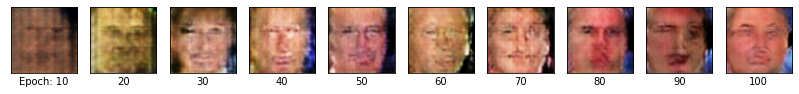

In [ ]:
tf.random.set_seed(7)
np.random.seed(7)

visualize_training(seed=7)

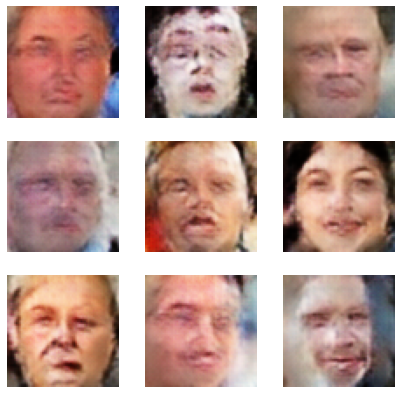

In [ ]:
tf.random.set_seed(7)
np.random.seed(7)

model = tf.keras.models.load_model("/content/drive/MyDrive/models/gen_{}".format(250), compile=False)

sample(model, size=(3, 3), seed=7)

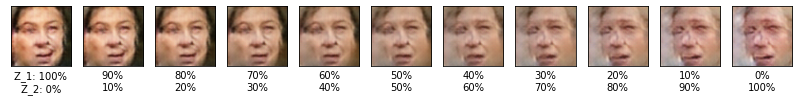

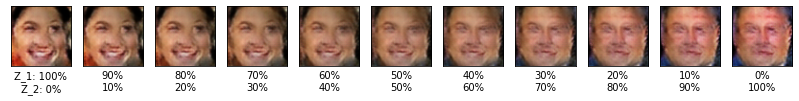

In [ ]:
tf.random.set_seed(7)
np.random.seed(7)

z1 = tf.random.normal([1, 100], seed=6)
z2 = tf.random.normal([1, 100], seed=6)
interpolate(model, z1, z2)

z1 = tf.random.normal([1, 100], seed=9)
z2 = tf.random.normal([1, 100], seed=9)
interpolate(model, z1, z2)